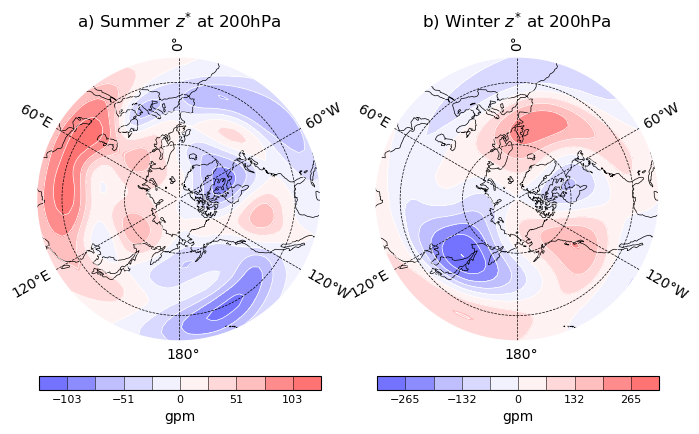

In [21]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmaps
import pandas as pd

from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point
from matplotlib import gridspec
from matplotlib import ticker
from matplotlib.ticker import MultipleLocator
from matplotlib.path import Path
from mpl_toolkits.axes_grid1.inset_locator import inset_axes



def round_boundary(lon, lat, dx=1):
    """
    对经纬度进行等角度划分，返回划分后的经纬度
    :param lon: 经度
    :param lat: 纬度
    :param n: 划分的角度
    :return: 划分后的经纬度
    """
    latmin = lat[0]
    latmax = lat[1]
    lonmin = lon[0]
    lonmax = lon[1]
    vertices = [(lon, latmin) for lon in range(lonmin, lonmax + 1, dx)] + [(lon, latmax) for lon in range(lonmax, lonmin - 1, -dx)]
    boundary = Path(vertices)
    return boundary


DOE_R2 = xr.open_dataset(r"C:\Users\10574\Desktop\hgt.mon.mean.nc").sel(time=slice('1981-01-01', '2023-12-31'))
# 绘制冬季（12~1月）和夏季（6~8月）平均北半球（20°N以北） 200hPa 位势高度显示的大气定常波
hgt_winter = DOE_R2.sel(level=200, time=DOE_R2['time.month'].isin([12, 1])).mean('time')
hgt_summer = DOE_R2.sel(level=200, time=DOE_R2['time.month'].isin([6, 7, 8])).mean('time')
# 计算纬偏值
hgt_winter = hgt_winter - hgt_winter.mean('lon')
hgt_summer = hgt_summer - hgt_summer.mean('lon')
# 绘图，左图显示夏天，右图显示冬天,兰勃托投影
fig = plt.figure(figsize=(8, 4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
proj = ccrs.NorthPolarStereo(central_longitude=180)
ax1 = fig.add_subplot(gs[0], projection=proj)
ax2 = fig.add_subplot(gs[1], projection=proj)
ax1.set_title('a) Summer $z^{*}$ at 200hPa', fontsize=12)
ax2.set_title('b) Winter $z^{*}$ at 200hPa', fontsize=12)
# 设置地图范围
ax1.set_extent([-180, 180, 20, 90], crs=ccrs.PlateCarree())
ax1.set_boundary(round_boundary([-180, 180], [20, 90]), transform=ccrs.PlateCarree(central_longitude=0))
ax2.set_extent([-180, 180, 20, 90], crs=ccrs.PlateCarree())
ax2.set_boundary(round_boundary([-180, 180], [20, 90]), transform=ccrs.PlateCarree(central_longitude=0))
# 添加地图要素
ax1.add_feature(cfeature.COASTLINE.with_scale('110m'), linewidth=0.5)
ax2.add_feature(cfeature.COASTLINE.with_scale('110m'), linewidth=0.5)
# 设置刻度线
gl1 = ax1.gridlines(  xlocs=np.arange(-180, 180, 60), ylocs=np.arange(30, 90, 30),
                draw_labels=True, x_inline=False, y_inline=False,
                linewidth=0.5, linestyle='--', color='k')
ax1.text(175.5, 13, '180°', transform=ccrs.PlateCarree())
for spine in ax1.spines.values():
    spine.set_edgecolor('none')
gl2 = ax2.gridlines(  xlocs=np.arange(-180, 180, 60), ylocs=np.arange(30, 90, 30),
                draw_labels=True, x_inline=False, y_inline=False,
                linewidth=0.5, linestyle='--', color='k')
ax2.text(175.5, 13, '180°', transform=ccrs.PlateCarree())
for spine in ax2.spines.values():
    spine.set_edgecolor('none')
# 绘制等值线
clevs = 10
summer, lon_s = add_cyclic_point(hgt_summer['hgt'].data, coord=hgt_summer['lon'])
winter, lon_w = add_cyclic_point(hgt_winter['hgt'].data, coord=hgt_winter['lon'])
contourf1 = ax1.contourf(lon_s, hgt_summer['lat'], summer, np.linspace(-np.nanmax(np.abs(summer)).astype(int), np.nanmax(np.abs(summer)), 11).astype(int), cmap=cmaps.GMT_polar[4:-4], transform=ccrs.PlateCarree(central_longitude=0))
contourf2 = ax2.contourf(lon_w, hgt_winter['lat'], winter, np.linspace(-np.nanmax(np.abs(winter)).astype(int), np.nanmax(np.abs(winter)), 11).astype(int), cmap=cmaps.GMT_polar[4:-4], transform=ccrs.PlateCarree(central_longitude=0))
contour1 = ax1.contour(lon_s, hgt_summer['lat'], summer, np.linspace(-np.nanmax(np.abs(summer)).astype(int), np.nanmax(np.abs(summer)).astype(int), 11), colors='w', linewidths=0.5, linestyles='solid', transform=ccrs.PlateCarree(central_longitude=0))
contour2 = ax2.contour(lon_w, hgt_winter['lat'], winter, np.linspace(-np.nanmax(np.abs(winter)).astype(int), np.nanmax(np.abs(winter)).astype(int), 11), colors='w', linewidths=0.5, linestyles='solid', transform=ccrs.PlateCarree(central_longitude=0))
cbar_ax = inset_axes(ax1, width='100%', height='5%', loc='lower left', bbox_to_anchor=(-0.02, -0.2, 1, 1), bbox_transform=ax1.transAxes)
cbar = plt.colorbar(contourf1, cax=cbar_ax, orientation='horizontal', drawedges=True)
cbar.ax.tick_params(length=0, labelsize=8)  # length为刻度线的长度
cbar.set_label('gpm', fontsize=10)
cbar_ax = inset_axes(ax2, width='100%', height='5%', loc='lower left', bbox_to_anchor=(-0.02, -0.2, 1, 1), bbox_transform=ax2.transAxes)
cbar = plt.colorbar(contourf2, cax=cbar_ax, orientation='horizontal', drawedges=True)
cbar.ax.tick_params(length=0, labelsize=8)  # length为刻度线的长度
cbar.set_label('gpm', fontsize=10)
plt.savefig(r'C:\Users\10574\Desktop\pic1.png', dpi=600, bbox_inches='tight')

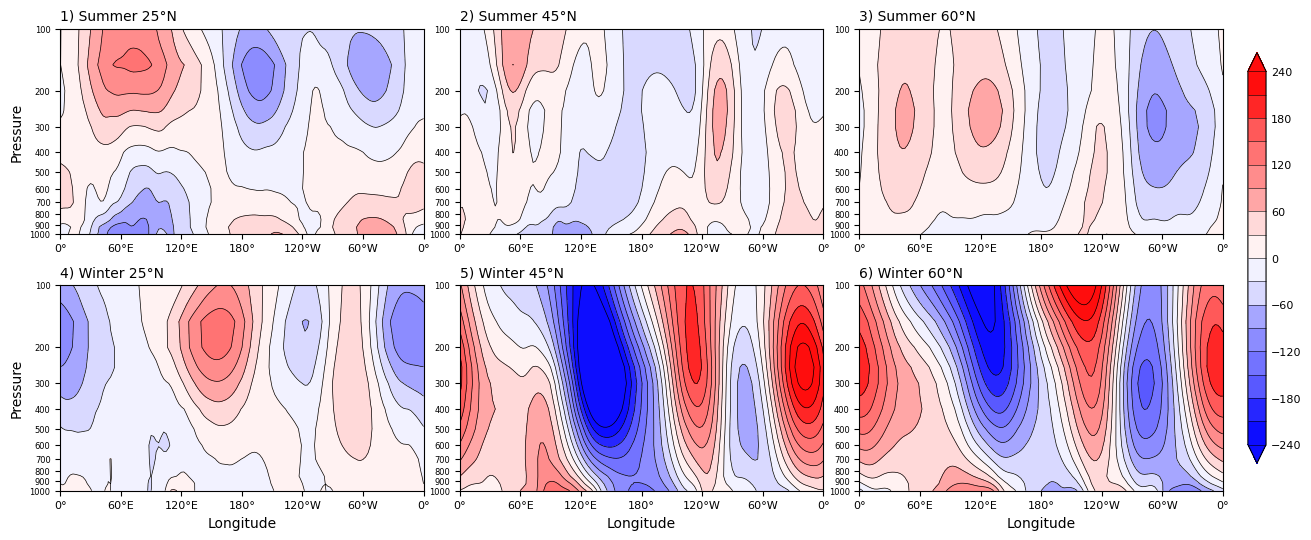

In [44]:
# 冬季（12~1月）和夏季（6~8月）平均北半球（20°N以北） 200hPa 位势高度沿不同纬度（25°N、45°N 和 60°N） 100hPa-1000hPa 的纬向—垂直剖面图
winter_p = DOE_R2.sel(lat=[25, 45, 60],level=slice(1000, 100), time=DOE_R2['time.month'].isin([12, 1])).mean('time')
summer_p = DOE_R2.sel(lat=[25, 45, 60],level=slice(1000, 100), time=DOE_R2['time.month'].isin([6, 7, 8])).mean('time')
# 计算纬偏值
winter_p = winter_p - winter_p.mean('lon')
summer_p = summer_p - summer_p.mean('lon')
# 绘垂直剖面图, 第一行显示夏季，第二行显示冬季
fig = plt.figure(figsize=(15, 6))
gs = gridspec.GridSpec(2, 3)
Season = ['Summer', 'Winter']
lat = [25, 45, 60]
for iSeason in range(2):
    for iLat in range(3):
        ax = fig.add_subplot(gs[iSeason, iLat])
        ax.set_title(f'{iSeason*3 + iLat + 1}) {Season[iSeason]} {lat[iLat]}°N', fontsize=10, loc='left')
        # y
        ax.set_ylim(1000, 100)
        ax.set_yscale('log')
        if iLat == 0: ax.set_ylabel('Pressure', fontsize=10)
        ax.set_yticks(np.arange(1000, 100 - 1, -100))
        ax.set_yticklabels(np.arange(1000, 100 - 1, -100), fontsize=6)
        # x
        if iSeason == 1: ax.set_xlabel('Longitude', fontsize=10)
        ax.set_xlim(0, 360)
        ax.set_xticks(np.arange(0, 360 + 1, 60))
        ax.set_xticklabels(['0°', '60°E', '120°E', '180°', '120°W', '60°W', '0°'], fontsize=8)
        lev = range(-240, 241, 30)
        if iSeason == 0:
            summer_p_fillwhite, lon_s = add_cyclic_point(summer_p.sel(lat=lat[iLat])['hgt'].data, coord=summer_p['lon'])
            contourf1 = ax.contourf(lon_s, summer_p['level'], summer_p_fillwhite, levels=lev, cmap=cmaps.GMT_polar, extend='both')
            ax.contour(lon_s, summer_p['level'], summer_p_fillwhite, levels=lev, colors='k', linewidths=0.5, linestyles='solid')
        else:
            winter_p_fillwhite, lon_w = add_cyclic_point(winter_p.sel(lat=lat[iLat])['hgt'].data, coord=winter_p['lon'])
            contourf1 = ax.contourf(lon_w, winter_p['level'], winter_p_fillwhite, levels=lev, cmap=cmaps.GMT_polar, extend='both')
            ax.contour(lon_w, winter_p['level'], winter_p_fillwhite, levels=lev, colors='k', linewidths=0.5, linestyles='solid')
cbar_ax = inset_axes(ax, width='5%', height='200%', loc='lower left', bbox_to_anchor=(1.05, 0.1, 1, 1), bbox_transform=ax.transAxes)
cbar = plt.colorbar(contourf1, cax=cbar_ax, orientation='vertical', drawedges=True)
cbar.ax.tick_params(length=0, labelsize=8)  # length为刻度线的长度
fig.subplots_adjust(hspace=0.25, wspace=0.1)
plt.savefig(r'C:\Users\10574\Desktop\pic2.png', dpi=600, bbox_inches='tight')